# Adapted from Hw5 Problem 2


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    return eta*(reg*Ui-(Yij - np.dot(Ui,Vj))*Vj)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    
    return eta*(reg*Vj - (Yij - np.dot(Ui,Vj))*Ui)

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    num_entries = np.shape(Y)[0]
    error = reg/2*((np.linalg.norm(U))**2 + (np.linalg.norm(V))**2) 
    for entry in range(num_entries):
        i = Y[entry, 0]
        j = Y[entry, 1]
        Yij = Y[entry, 2]
        error  =  error + 1/2*(Yij - np.dot(U[i,:],V[j,:]))**2
    
    return error/len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=100):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    #Initialize U and V
    U  = np.random.uniform(-.5,.5,(M+1,K))
    V  = np.random.uniform(-.5,.5,(N+1,K))
    
    zeroth_err = get_err(U, V, Y, reg)
    past_err = zeroth_err
    #Shuffle training data
    np.random.shuffle(Y)
    
    for epoch in range(max_epochs):
        print(epoch)
        num_entries = np.shape(Y)[0]
        for entry in range(num_entries):
            i = Y[entry, 0]
            j = Y[entry, 1]
            Yij = Y[entry, 2]

            Ui = U[i,:]
            Vj = V[j,:]

            delta_u = grad_U(Ui, Yij, Vj, reg, eta)
            delta_v = grad_V(Vj, Yij, Ui, reg, eta)

            U[i,:] = U[i,:] -  delta_u
            V[j,:] = V[j,:] -  delta_v
        
        #get the error for this epoch
        err =  get_err(U, V, Y, reg)
        nth_rel_err = abs(past_err - err)
        past_err = err
        
        if (epoch == 0):
            first_err = err
            first_rel_err = abs(zeroth_err-first_err)
            
        if (nth_rel_err/first_rel_err < .0001):
            break 
    
    return (U, V, err)

In [3]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

fix_indices = np.append(np.ones((90000,2)),np.zeros((90000,1)), axis = 1)
Y_train = (Y_train - fix_indices).astype(int)

fix_indices = np.append(np.ones((10000,2)),np.zeros((10000,1)), axis = 1)
Y_test = (Y_test - fix_indices).astype(int)


M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

U,V, err = train_model(M, N, K, eta, reg, Y_train)

Factorizing with  942  users,  1681  movies.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


Find the best value of regs

In [4]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

fix_indices = np.append(np.ones((90000,2)),np.zeros((90000,1)), axis = 1)
Y_train = (Y_train - fix_indices).astype(int)

fix_indices = np.append(np.ones((10000,2)),np.zeros((10000,1)), axis = 1)
Y_test = (Y_test - fix_indices).astype(int)


M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
Ks = [20]

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for k in Ks:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
        U,V, e_in = train_model(M, N, k, eta, reg, Y_train)
        E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, Y_test)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)


# Plot values of E_in across k for each value of lambda
#for i in range(len(regs)):
#    plt.plot(Ks, E_ins[i], label='$E_{in}, \lambda=$'+str(regs[i]))
#plt.title('$E_{in}$ vs. K')
#plt.xlabel('K')
#plt.ylabel('Error')
#plt.legend()
#plt.savefig('2e_ein.png')	
#plt.clf()

# Plot values of E_out across k for each value of lambda
#for i in range(len(regs)):
#    plt.plot(Ks, E_outs[i], label='$E_{out}, \lambda=$'+str(regs[i]))
#plt.title('$E_{out}$ vs. K')
#plt.xlabel('K')
#plt.ylabel('Error')
#plt.legend()	
#plt.savefig('2e_eout.png')		


Training model with M = 942, N = 1681, k = 20, eta = 0.03, reg = 0.0001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Training model with M = 942, N = 1681, k = 20, eta = 0.03, reg = 0.001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Training model with M = 942, N = 1681, k = 20, eta = 0.03, reg = 0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Training model with M = 942, N = 1681, k = 20, eta = 0.03, reg = 0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Training model with M = 942, N = 1681, k = 20, eta = 0.03, reg = 1
0
1
2
3
4
5
6
7
8
9


In [5]:
E_ins

[[0.18979766183929184],
 [0.19343549092479978],
 [0.19121933384500223],
 [0.28483674738331743],
 [0.9933886321813884]]

In [6]:
E_outs

[[0.711206001032413],
 [0.677130092784758],
 [0.6216022315603412],
 [0.44511083266640933],
 [0.9760733587705196]]

In [7]:
U,V, e_in = train_model(M, N, 20, .03, 10**-1, Y_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [8]:
U = np.transpose(U)
V = np.transpose(V)

In [9]:
means = []
for i in range(np.shape(V)[1]):
    means.append(np.transpose(np.mean(V,1)))
means = np.transpose(means)
V = V - means 

means = []
for i in range(np.shape(U)[1]):
    means.append(np.transpose(np.mean(V,1)))
means = np.transpose(means)
U = U - means


#Get SVD

A, S, B = np.linalg.svd(V)
V_tilde = np.matmul(np.transpose(A[:,0:2]),V)

A, S, B = np.linalg.svd(U)
U_tilde = np.matmul(np.transpose(A[:,0:2]),U)

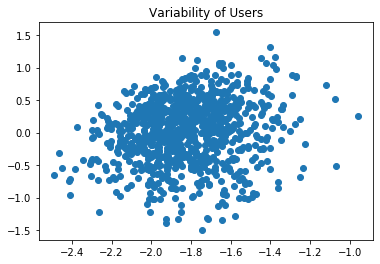

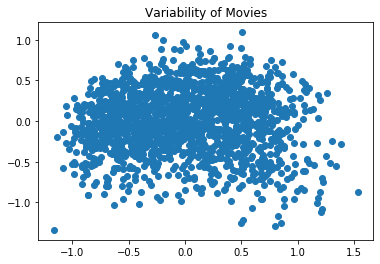

In [22]:
plt.title("Variability of Users")
plt.plot(U_tilde[0], U_tilde[1], "o")
plt.show()


plt.title("Variability of Movies")
plt.plot(V_tilde[0], V_tilde[1], "o")
#plt.xlim(min, 2.5)
#plt.ylim(-1.5, 1.5)
plt.show()

In [21]:
data   = np.loadtxt('./data/data.txt').astype(int)
movies = pd.read_csv('./data/movies.txt', sep="\t", names=["id", "title", \
                    "unknown", "action", "adventure", "animation", "childrens", \
                    "comedy", "crime", "documentary", "drama", "fantasy", 
                    "film-noir", "horror", "musical", "mystery", "romance", \
                    "sci-fi", "thriller", "war", "western"])

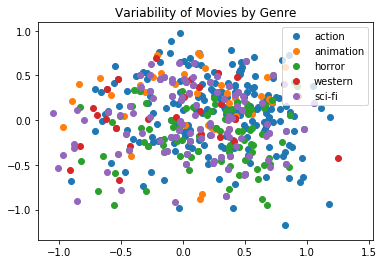

In [28]:
action = movies[movies['action'] == 1]
act_id = np.array(action['id'])-1

animation = movies[movies['animation'] == 1]
ani_id = np.array(animation['id'])-1

horror = movies[movies['horror'] == 1]
hor_id = np.array(horror['id'])-1

western = movies[movies['western'] == 1]
wes_id = np.array(western['id'])-1

scifi = movies[movies['sci-fi'] == 1]
sci_id = np.array(scifi['id'])-1

plt.plot(V_tilde[0, act_id], V_tilde[1, act_id], "o", label="action")
plt.plot(V_tilde[0, ani_id], V_tilde[1, ani_id], "o",label="animation")
plt.plot(V_tilde[0, hor_id], V_tilde[1, hor_id], "o", label="horror")
plt.plot(V_tilde[0, wes_id], V_tilde[1, wes_id], "o", label="western")
plt.plot(V_tilde[0, sci_id], V_tilde[1, sci_id], "o", label="sci-fi")

plt.title("Variability of Movies by Genre")
plt.legend()
plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()

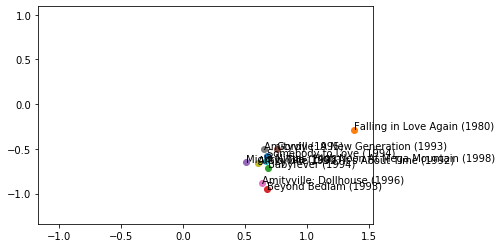

In [29]:

# Find the ten worst movies.
n_movies = 1682

# Array indicating movie average ratings and popularities
onestar_films = []
onestar_pops  = []
mov_avg = np.zeros(n_movies)
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    if avg == 1:
        pop = len(np.where(data[:, 1] == movie_index)[0])
        onestar_films.append(movie_index)
        onestar_pops.append(pop)

onestar_films = np.array(onestar_films)
onestar_pops = np.array(onestar_pops)

onestar_idx = onestar_films[np.argsort(onestar_pops)[-10:]]-1
    
worst_titles = np.array(movies.iloc[onestar_idx]['title'])

V_tilde_worst = V_tilde[:, onestar_idx]

for i in range(10):
    plt.plot(V_tilde_worst[0][i], V_tilde_worst[1][i], "o")
    plt.text(V_tilde_worst[0][i], V_tilde_worst[1][i], worst_titles[i])

plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()

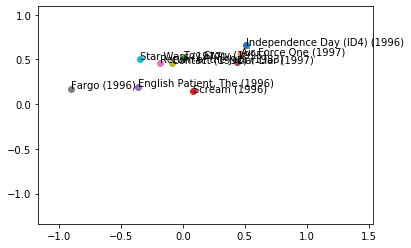

In [30]:
# Find the ten most popular movies.
n_movies = 1682

# Array indicating movie popularity.
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop
    
top_movies = np.argsort(mov_pop)[-10:]

top_titles = np.array(movies.iloc[top_movies]['title'])

V_tilde_top = V_tilde[:, top_movies]

for i in range(10):
    plt.plot(V_tilde_top[0][i], V_tilde_top[1][i], "o")
    plt.text(V_tilde_top[0][i], V_tilde_top[1][i], top_titles[i])
    
plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()

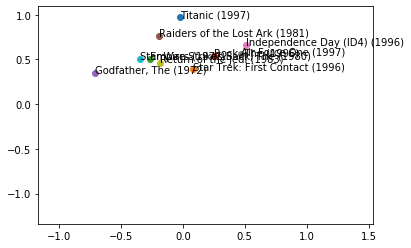

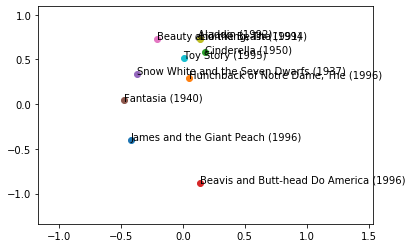

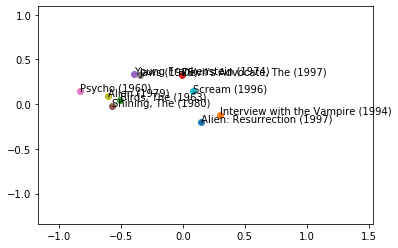

In [32]:
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop


action = movies[movies['action'] == 1]
act_id = np.array(action['id'])
act_pop = mov_pop[act_id-1]

top_act = np.argsort(act_pop)[-10:]
top_act_id = act_id[top_act]
act_titles = np.array(action.iloc[top_act]['title'])


animation = movies[movies['animation'] == 1]
ani_id = np.array(animation['id'])
ani_pop = mov_pop[ani_id-1]

top_ani = np.argsort(ani_pop)[-10:]
top_ani_id = ani_id[top_ani]
ani_titles = np.array(animation.iloc[top_ani]['title'])


horror = movies[movies['horror'] == 1]
hor_id = np.array(horror['id'])
hor_pop = mov_pop[hor_id-1]

top_hor = np.argsort(hor_pop)[-10:]
top_hor_id = hor_id[top_hor]
hor_titles = np.array(horror.iloc[top_hor]['title'])


for i in top_act_id:
    plt.plot(V_tilde[0][i-1], V_tilde[1][i-1], "o")
    plt.text(V_tilde[0][i-1], V_tilde[1][i-1], movies['title'][i-1])
plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()    
    
for i in top_ani_id:
    plt.plot(V_tilde[0][i-1], V_tilde[1][i-1], "o")
    plt.text(V_tilde[0][i-1], V_tilde[1][i-1], movies['title'][i-1])
plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()    
    
for i in top_hor_id:
    plt.plot(V_tilde[0][i-1], V_tilde[1][i-1], "o")
    plt.text(V_tilde[0][i-1], V_tilde[1][i-1], movies['title'][i-1])
plt.xlim(min(V_tilde[0]), max(V_tilde[0]))
plt.ylim(min(V_tilde[1]),max(V_tilde[1]))
plt.show()